In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test
!pip install anndata 
!pip install git+https://github.com/theislab/scgen.git
!pip install matplotlib
!pip install scanpy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/theislab/scgen.git to /tmp/pip-req-build-4gnz2q_4
  Running command git clone --filter=blob:none --quiet https://github.com/theislab/scgen.git /tmp/pip-req-build-4gnz2q_4
  Resolved https://github.com/theislab/scgen.git to commit 06084773e56cad0dec340138441dee47a39af752
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [ ]:
import anndata
import scanpy as sc
import scgen
import pandas as pd  
import numpy as np

font = {'family' : 'Arial',
        'size'   : 14}

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")
sc.pp.normalize_total(train, target_sum=1e4)
sc.pp.log1p(train)

In [ ]:
print(train.X.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(train.obs['perturbation'].unique())

['STAT2g2', 'CAV1g4', 'STAT1g2', 'CD86g1', 'IRF7g2', ..., 'SPI1g3', 'PDCD1LG2g2', 'CUL3g3', 'SPI1g2', 'MYCg4']
Length: 99
Categories (99, object): ['ATF2g1', 'ATF2g2', 'ATF2g3', 'ATF2g4', ..., 'UBE2L6g2', 'UBE2L6g3',
                          'UBE2L6g4', 'control']


In [ ]:
print(train.obs['perturbation'])

AAACCTGAGCCAGAAC    STAT2g2
AAACCTGAGTGGACGT     CAV1g4
AAACCTGCATGAGCGA    STAT1g2
AAACCTGTCTTGTCAT     CD86g1
AAACGGGAGAACAACT     IRF7g2
                     ...   
TTTGTCAGTCACTTCC    CMTM6g1
TTTGTCAGTGACGGTA    control
TTTGTCAGTTCCACAA     ATF2g1
TTTGTCATCACGCATA     CAV1g2
TTTGTCATCTGTACGA    STAT3g1
Name: perturbation, Length: 20729, dtype: category
Categories (99, object): ['ATF2g1', 'ATF2g2', 'ATF2g3', 'ATF2g4', ..., 'UBE2L6g2', 'UBE2L6g3',
                          'UBE2L6g4', 'control']


In [ ]:
prt=train.obs['perturbation'].unique()
list_prt=list(prt)
len(list(prt))
list_prt.remove('control')
len(list_prt)

98

In [ ]:
train[train.obs['perturbation']=='control'].X

<2386x18649 sparse matrix of type '<class 'numpy.float32'>'
	with 8032261 stored elements in Compressed Sparse Column format>

In [ ]:


import random

def subset(alist, idxs):
    '''
        use idxs to subset alist
        alist: list
        idxs: list
    '''
    sub_list = []
    for idx in idxs:
        sub_list.append(alist[idx])

    return sub_list

def split_list(alist, group_num=3, shuffle=True, retain_left=False):
    '''
        split data into 3 subset and let each subset contains the len(alist)//group number of elements
        shuffle: whether shuffle the splitted data, default: True
        retain_left: if list alist is splited into the number of group_num subset and there is some element remain，
        whether take the remaining elements as a subset
    '''

    index = list(range(len(alist))) 

    
    if shuffle: 
        random.shuffle(index) 
    
    elem_num = len(alist) // group_num 
    sub_lists = {}
    
   
    for idx in range(group_num):
        start, end = idx*elem_num, (idx+1)*elem_num
        sub_lists[str(idx)] = subset(alist, index[start:end])
    
  
    if retain_left and group_num * elem_num != len(index): 
        sub_lists[str(idx+1)] = subset(alist, index[end:])
    
    return sub_lists



def sample_control_control(adata,size_n):
    """
    the sampling for ctrl and ctrl
    split the data into three samples
    shuffle the three samples
    return two data set have maximum between-sample distance
    
    """
    x = adata.X
    n_rows=x.shape[0]
    index_dict=split_list(range(n_rows))# in form {0: [1,2,3],1:[3,44,2...],3:[]}
    sample1=x[index_dict['0'],:size_n].toarray()
    sample2=x[index_dict['1'],:size_n].toarray()
    sample3=x[index_dict['2'],:size_n].toarray() 
  
    return sample1,sample2,sample3
        


In [ ]:
#we use a function to get control and 98 stim data in order to compare the control data with each stim data 

def sample_obs(x,size_n):
    """
    params 
    -------------
    sample for all control and stim pairs 
    size_n:the number of rows we will consider in comparison
    output x,y in sparse matrix form
    which is sample1 and sample2 drawn from two specified codition
    """

    # x = adata.X
    #print(x.shape)(16893, 6998)
    n_rows=x.shape[0]
    
    df = pd.DataFrame({'x':np.arange(n_rows)})
    #shuffle the data index
#     x_sample1=df['x'].sample(frac=1, replace=False).values[:size_n]
    x_sample1=df['x'].values[:size_n]
    
    return x[x_sample1,:]


def data_prep(adata,ctrl,conditions,sample_ctrl=False):
    """
    param
    -----------
    adata
    return_mean: bool variable True if we want to compute mean of sampled data per cell to
    find statistic between mean of data from sample1 and sample2
    output: the sampled data from sample1 and sample2 of type array
    """
    
    control = adata[adata.obs["perturbation"] == "control"]
    stim = adata[adata.obs["perturbation"] == conditions].X

    control=ctrl
    #fix the number of rows of sampled data as the minimum number of rows between sample1,sample2
    n=np.minimum(control.shape[0],stim.shape[0])
    
    
    x= sample_obs(control,n)
    y= sample_obs(stim,n)
        
    # x=x.toarray()
    y=y.toarray()

    # print(ctrl.shape, y.shape)
        
    
    return x,y
 
def compute_from_mean(x,y,fn,if_return=False):
    """
    param
    -------
    x,y:data from sample1 and sample2
    fn: the statistic function with input x,y
    print statistic computed with mean of sample 1 and 2
    """ 
    
    x_mean = np.mean(x, axis=0).ravel()
    y_mean = np.mean(y, axis=0).ravel()
    mean = fn(x_mean,y_mean)
#     print("statistic computed with mean of sample 1 and 2:",mean)
    if if_return:
        return mean

def compute_from_sample(x,y,fn):
    """
    param
    -----------
    x,y:sampled data from sample1 and sample2 in sparse matric form
    output: the average of statistic computed between each data from sample1 and sample2
    """
#     x=x.toarray()
#     y=y.toarray()
    a=dict.fromkeys(range(x.shape[0]))
    
    for i in range(x.shape[0]):
        a[i]=fn(x[i],y[i])
        
    return np.mean(list(a.values()))

def dist_based(x,y):
    """
    transpose the data so that we can compute static between genes (columns)
    """
    m=np.minimum(x.shape[0],y.shape[0])
    x=x.T[:,:m]#delete .toarray()
    y=y.T[:,:m]
    return x,y


def test(fn,train,metric_str):
    """
    fn: the function for computing specific statistic to apply 
    print out the test result for statistic between (stim,ctrl) and (ctrl,ctrl)
    
    """
    # list_stim=list(train.obs['perturbation'].unique())
    # list_stim.remove('control')
    stim=train[train.obs['perturbation']!="control"]
    filtered_obs = stim.obs[stim.obs['perturbation'].map(stim.obs['perturbation'].value_counts()) >= 110]
    obs_list=filtered_obs['perturbation'].unique()
    list_stim=list(obs_list)
    
    conditions={"x":"control","y":"stim"}
    
    difference=[]
    control = train[train.obs["perturbation"] == conditions["x"]]
    
    sample1,sample2,sample3=sample_control_control(control,control.shape[1])
    # print(sample1.shape)
    pairs={}
    pairs[0]=(sample1,sample2)
    pairs[1]=(sample1,sample3)
    pairs[2]=(sample2,sample3)
    for i in range(3):
        (x,y)=pairs[i]
        print("mean of computed statistics for (contrl, control):",fn(train,None,conditions,True,x,y))
        #set the sample_ctrl True
        difference.append(fn(train,None,conditions,True,x,y))
        
    zero=['control']*3
    if_stim=['stim']*len(list_stim)
    
    for stim in list_stim:
      # str(stim)
      out1=fn(adata=train,ctrl=sample1,conditions=str(stim))
      out2=fn(adata=train,ctrl=sample2,conditions=str(stim))
      out3=fn(adata=train,ctrl=sample3,conditions=str(stim))
      difference.append((out1+out2+out3)/3)
#         print(conditions)
#         print("mean of computed statistics:",fn(train,conditions))
        
    
    #lastly,for (ctrl,ctrl) where we apply a different sampling method, get three points 
    
    
    if_stim= zero + if_stim
    metric=[metric_str]*len(if_stim)
        
    return difference,if_stim,metric    
              
              

In [ ]:
from scipy import stats
    
def average_dist_metric(x,y,fn):
    kl=0
    count_nan=0
    for i in range(x.shape[0]):

        sparse=np.absolute(fn(x[i],y[i]))
        if np.isnan(sparse):#nan: caused by division by 0-vector(vec of all 0)
            count_nan+=1   
        else:
            kl+=sparse
    if x.shape[0]==count_nan:
        return 0 # note that 0 for t-statistics  means that the result is inconclusive and more data may be needed to make a definitive conclusion.
    else:
        return kl/(x.shape[0]-count_nan)
    
def t_test(adata,ctrl,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)
    x,y=dist_based(x,y)#only for distribution based methods
    fn=lambda x,y: stats.ttest_ind(x,y, equal_var=True)[0]
    return average_dist_metric(x,y,fn)



mean of computed statistics for (contrl, control): 0.7992797756380692
mean of computed statistics for (contrl, control): 0.7963207426283998
mean of computed statistics for (contrl, control): 0.8104283785268409


<Axes: xlabel='metric', ylabel='difference'>

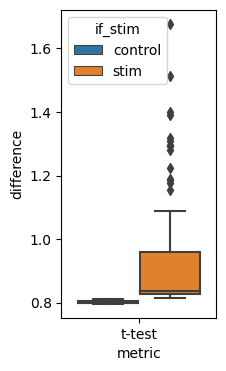

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
difference5,if_stim5,metric5=test(t_test,train,'t-test')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference5, 'if_stim':if_stim5, 'metric':metric5})
df.to_csv("t_statistic.csv",index=False)
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

mean of computed statistics for (contrl, control): 0.00011292173
mean of computed statistics for (contrl, control): 0.0001117385
mean of computed statistics for (contrl, control): 0.00011281383


<Axes: xlabel='metric', ylabel='difference'>

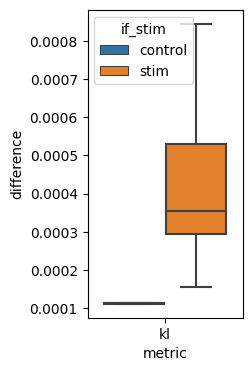

In [ ]:
from scipy.spatial import distance
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

#distribution based metrics 
#use Jensen-Shannon divergence to replace formula of kl divergence since kl diergence has
#inf result for sparse data 
def kl2(x,y):
  input=np.log(np.exp(x) / np.sum(np.exp(x)))
  target=np.exp(y)/np.sum(np.exp(y))
  loss= target*(np.log(target) - input)
  return loss
    
def calc_kl(adata,ctrl,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)
    x,y=dist_based(x,y)#only for distribution based methods
    
    return compute_from_sample(x,y,kl2)

difference4,if_stim4,metric4=test(calc_kl,train,'kl')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference4, 'if_stim':if_stim4, 'metric':metric4})
df.to_csv("kl.csv",index=False)
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

In [ ]:
from scipy import stats
def calc_pearson(adata,ctrl,conditions, sample_ctrl=False,ctrl1=None,ctrl2=None):
    """
    param
    ---------
    adata
    condition: dictionary pass to adata to get sample1 and sample2 from specific 'condition'
    fn: function for computing pearson coefficient 
    -----------
    output: the average of pearson coefficient computed between each data from sample1 and sample2
    """
    fn=lambda x,y: stats.pearsonr(x,y).statistic
    
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)
      
    
    compute_from_mean(x,y,fn,sample_ctrl)
    
    
    pearson_obs=dict.fromkeys(range(x.shape[0]))
    for i in range(x.shape[0]):
        #use pd
        df = pd.DataFrame({'x':x[i], 'y':y[i]})
        matrix=df.corr(method='pearson').values
        pearson_obs[i] = matrix[0,1]
    
    pr=list(pearson_obs.values())
    
    return np.mean(pr)

difference0,if_stim0,metric0=test(calc_pearson,train,'pearson')


mean of computed statistics for (contrl, control): 0.6556264505342595
mean of computed statistics for (contrl, control): 0.6516139261634395
mean of computed statistics for (contrl, control): 0.6496968590139302


<Axes: xlabel='metric', ylabel='difference'>

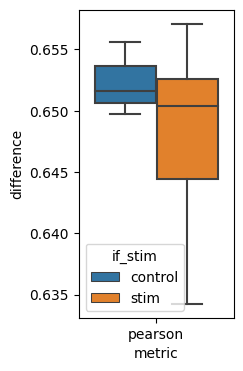

In [ ]:
import matplotlib.pyplot as plt
df=pd.DataFrame({'difference':difference0, 'if_stim':if_stim0, 'metric':metric0})
df.to_csv("pearson.csv",index=False)
plt.figure(figsize=(2, 4))
import seaborn as sns
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

In [ ]:

from scipy import stats
def calc_mae(adata,ctrl,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    fn=lambda x,y: np.mean(np.abs(y-x)) 
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)

    # compute_from_mean(x,y,fn)
    return compute_from_sample(x,y,fn)

difference,if_stim,metric=test(calc_mae,train,'mae')

mean of computed statistics for (contrl, control): 0.17187308
mean of computed statistics for (contrl, control): 0.17127891
mean of computed statistics for (contrl, control): 0.17082316


<Axes: xlabel='metric', ylabel='difference'>

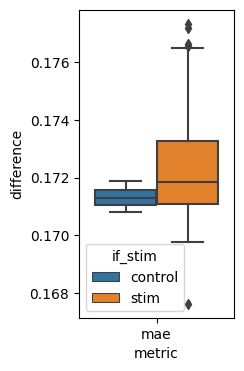

In [ ]:
# print(difference2,if_stim2,metric2)
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference, 'if_stim':if_stim, 'metric':metric})
df.to_csv("mae.csv",index=False)
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

mean of computed statistics for (contrl, control): 52.677902
mean of computed statistics for (contrl, control): 52.846935
mean of computed statistics for (contrl, control): 52.73522


<Axes: xlabel='metric', ylabel='difference'>

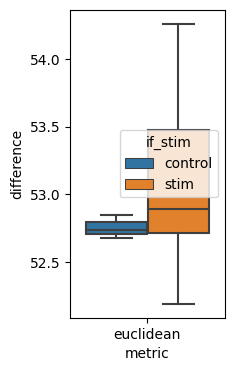

In [ ]:
def calc_euclidean_d(adata,ctrl,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    fn=lambda x,y: np.linalg.norm(x-y)
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)
    compute_from_mean(x,y,fn) 
    return compute_from_sample(x,y,fn)

difference2,if_stim2,metric2=test(calc_euclidean_d,train,'euclidean')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference2, 'if_stim':if_stim2, 'metric':metric2})
df.to_csv("euclidean_d.csv",index=False)
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")


In [ ]:

# print(train.X.toarray())
# print(X_norm.toarray())


mean of computed statistics for (contrl, control): 0.4263777747942079
mean of computed statistics for (contrl, control): 0.429805023827638
mean of computed statistics for (contrl, control): 0.431762422170451


<Axes: xlabel='metric', ylabel='difference'>

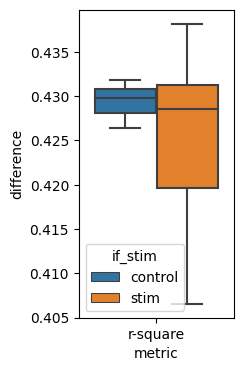

In [ ]:
def calc_r(adata,ctrl,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    fn=lambda x,y: stats.linregress(x,y)[2]**2
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)
    compute_from_mean(x,y,fn)
    return compute_from_sample(x,y,fn)

difference3,if_stim3,metric3=test(calc_r,train,'r-square')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference3, 'if_stim':if_stim3, 'metric':metric3})
df.to_csv("r_square.csv",index=False)
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

mean of computed statistics for (contrl, control): 0.00011605024337768555
mean of computed statistics for (contrl, control): 0.00011587142944335938
mean of computed statistics for (contrl, control): 0.00011607259511947632


<Axes: xlabel='metric', ylabel='difference'>

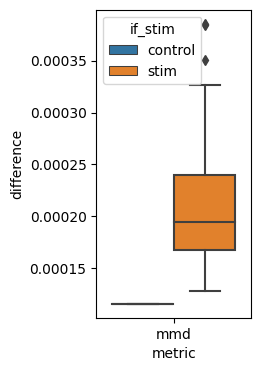

In [ ]:
from sklearn import metrics
#very slow ~20min
def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    
    # print("mmd")
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def mmd(adata,ctrl,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)
    x,y=dist_based(x,y)
    # print(mmd_rbf(x,y))

    return mmd_rbf(x,y)

difference6,if_stim6,metric6=test(mmd,train,'mmd')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference6, 'if_stim':if_stim6, 'metric':metric6})
df.to_csv("mmd.csv",index=False)
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

mean of computed statistics for (contrl, control): 0.010876964297224803
mean of computed statistics for (contrl, control): 0.011193688775156767
mean of computed statistics for (contrl, control): 0.0111349412281638


<Axes: xlabel='metric', ylabel='difference'>

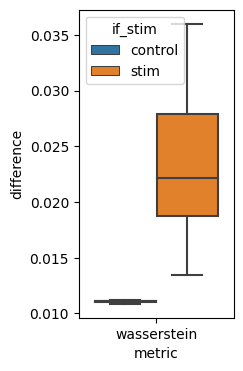

In [ ]:
def calc_wasserstein(adata,ctrl,conditions,sample_ctrl=False,ctrl1=None,ctrl2=None):
    fn=lambda x,y: stats.wasserstein_distance(x,y)
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x,y=data_prep(adata,ctrl,conditions)
    x,y=dist_based(x,y)
    return compute_from_sample(x,y,fn)


difference7,if_stim7,metric7=test(calc_wasserstein,train,'wasserstein')
plt.figure(figsize=(2, 4))
df=pd.DataFrame({'difference':difference7, 'if_stim':if_stim7, 'metric':metric7})
df.to_csv("wasserstein.csv",index=False)
sns.boxplot(data=df, x="metric", y="difference", hue="if_stim")

In [19]:
#correlation matrix 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
wasserstein=pd.read_csv("wasserstein.csv")
mmd=pd.read_csv("mmd.csv")
r_square=pd.read_csv("r_square.csv")
euclidean_d=pd.read_csv("euclidean_d.csv")
mae=pd.read_csv("mae.csv")
pearson=pd.read_csv("pearson.csv")
kl=pd.read_csv("kl.csv")
t_statistic=pd.read_csv("t_statistic.csv")
df=pd.DataFrame()
df["wasserstein"]=wasserstein['difference']
df["mmd"]=mmd['difference']
df["r_square"]=1/r_square['difference']
df["euclidean_d"]=euclidean_d['difference']
df["mae"]=mae['difference']
df["pearson"]=1/pearson['difference']
df["kl"]=kl['difference']
df["t_statistic"]=t_statistic['difference']
# df["genes"]=t_statistic['']
t_statistic

,difference,if_stim,metric
0,0.799280,control,t-test
1,0.796321,control,t-test
2,0.810428,control,t-test
3,0.893172,stim,t-test
4,0.830229,stim,t-test
...,...,...,...
63,0.822634,stim,t-test
64,0.823440,stim,t-test
65,1.292766,stim,t-test
66,1.295769,stim,t-test


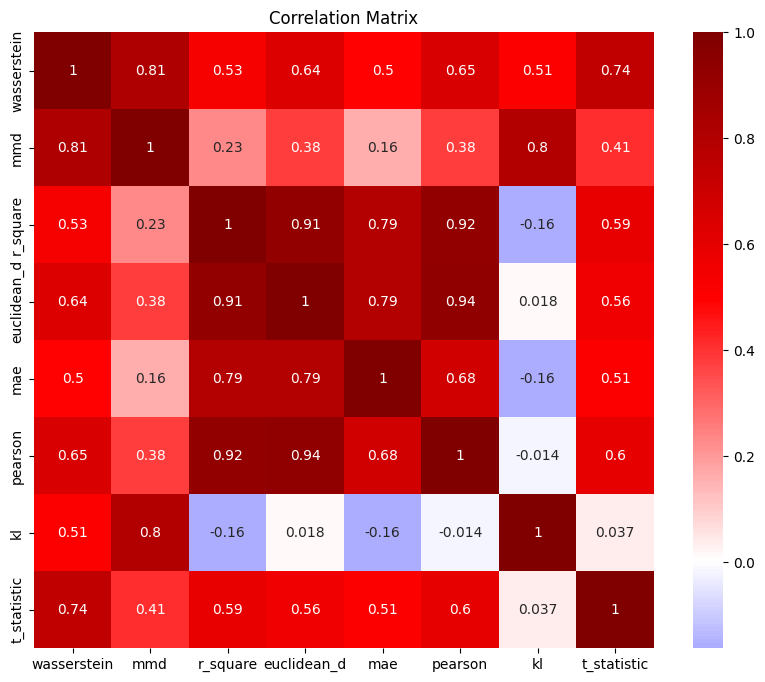

In [25]:
corr_matrix = df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='seismic',center=0)
plt.title('Correlation Matrix')
plt.show()

In [15]:
df.columns.values

array(['wasserstein', 'mmd', 'r_square', 'euclidean_d', 'mae', 'pearson',
       'kl', 't_statistic'], dtype=object)

    wasserstein       mmd  r_square  euclidean_d       mae   pearson  \
0      0.010877  0.000116  2.345338    52.677902  0.171873  1.525259   
1      0.011194  0.000116  2.326636    52.846935  0.171279  1.534651   
2      0.011135  0.000116  2.316089    52.735222  0.170823  1.539179   
3      0.020620  0.000168  2.318903    52.538991  0.171283  1.527833   
4      0.025600  0.000244  2.318937    52.896205  0.171161  1.537243   
..          ...       ...       ...          ...       ...       ...   
63     0.020882  0.000202  2.324591    52.715551  0.171689  1.533159   
64     0.016313  0.000146  2.337111    52.947266  0.171714  1.538094   
65     0.035982  0.000386  2.459572    54.109955  0.177192  1.575274   
66     0.032591  0.000235  2.449061    54.106333  0.176053  1.574299   
67     0.021185  0.000173  2.313528    52.549957  0.171455  1.526697   

          kl  t_statistic  
0   0.000113     0.799280  
1   0.000112     0.796321  
2   0.000113     0.810428  
3   0.000328     0.8931

Text(0, 0.5, 'Distance')

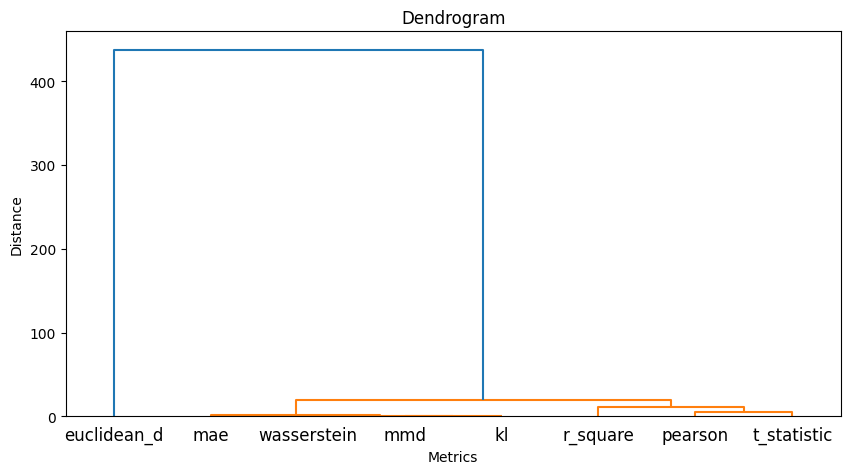

In [17]:
from scipy.cluster import hierarchy 
print(df)
distance_matrix=df.to_numpy().T
print(distance_matrix.shape)
linkage_matrix=hierarchy.linkage(distance_matrix, method='complete')
plt.figure(figsize=(10,5))
dendrogram=hierarchy.dendrogram(linkage_matrix,labels=df.columns.values)
plt.title('Dendrogram')
plt.xlabel('Metrics')
plt.ylabel('Distance')

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]


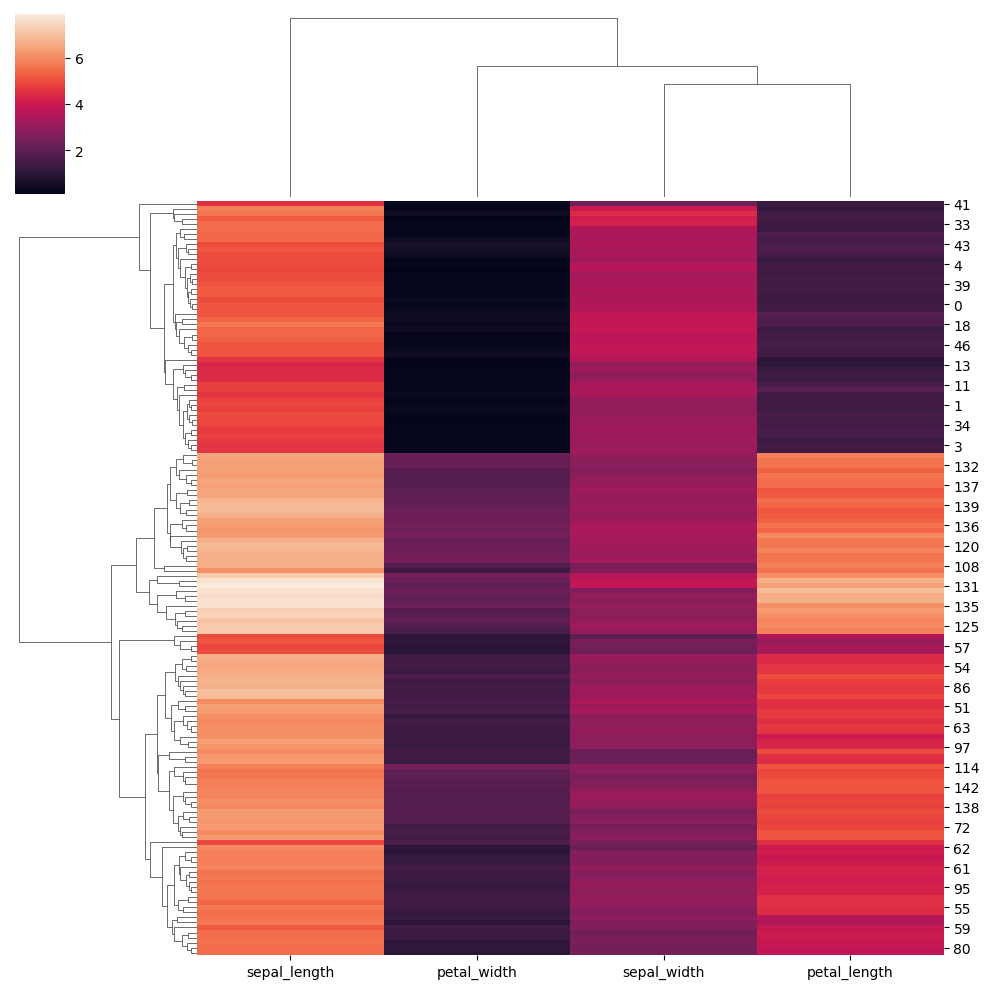

In [18]:
iris = sns.load_dataset("iris")
print(iris)

species = iris.pop("species")
sns.clustermap(iris)